## Simulation of dual phosphorylation-dephosphorylation cycle using Spatiocyte and ODE solver

In [1]:
import math
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from ecell4 import *
rng = GSLRandomNumberGenerator()

### Dual phosphorylation-dephosphorylation model and parameters

In [2]:
@species_attributes
def attrgen(radius, D):
    K | {"radius": radius, "D": D}
    Kp | {"radius": radius, "D": D}
    Kpp | {"radius": radius, "D": D}
    KK | {"radius": radius, "D": D}
    PP | {"radius": radius, "D": D}
    K_KK | {"radius": radius, "D": D}
    Kp_KK | {"radius": radius, "D": D}
    Kpp_PP | {"radius": radius, "D": D}
    Kp_PP | {"radius": radius, "D": D}
    C | {"radius": radius, "D": D}

@reaction_rules
def rulegen(kon1, koff1, kcat1, kon2, koff2, kcat2,k7):
    (KK + K == K_KK | (kon1, koff1)
        > Kp + KKa | kcat1)
    (KK + Kp == Kp_KK | (kon2, koff2)
        > Kpp + KKa | kcat2)
    (KKa > KK | k7)
    (Kpp + PP == Kpp_PP | (kon1, koff1)
        > Kp + PPa | kcat1)     
    (Kp + PP == Kp_PP | (kon2, koff2)
        > K + PPa | kcat2)
    (PPa > PP | k7)

@reaction_rules    
def rulegen2(kon1, koff1, kcat1, kcat2):
    (K + KK == K_KK | (kon1, koff1)
        > Kp_KK | kcat1
        > Kpp + KK | kcat2)

    (Kpp + PP == Kpp_PP | (kon1, koff1)
        > Kp + PP | kcat1
        > K + PP | kcat2)

ka1, kd1, kcat1 = 0.04483455086786913, 1.35, 1.5
ka2, kd2, kcat2 = 0.09299017957780264, 1.73, 15.0
trel = 1e-6
k7 = math.log(2)/trel
radius = 0.0025

### Simulator for Spatiocyte and ODE

In [3]:
def run(ratio,m):
    voxelr = 1.0208582*radius
    w = spatiocyte.SpatiocyteWorld(Real3(1, 1, 1),voxelr,rng)
    (c,r,l)=w.shape()
    Nev=(c - 2) * (r - 2) * (l - 2)
    w.bind_to(m)
    w.add_molecules(Species("K"), NKT)
    npp = int(60./(ratio+1))
    nkk = 60-npp
    w.add_molecules(Species("KK"), nkk)
    w.add_molecules(Species("PP"), npp)
    Nt=nkk+npp+NKT
    phil = 0.15*0.74/0.515
    Nc = int(Nev*phil)-Nt
    w.add_molecules(Species("C"), Nc)
    sim = spatiocyte.SpatiocyteSimulator(m, w)
    obs = FixedIntervalNumberObserver(1.0, ["KK","Kpp","PP"])
    sim.run(dur, [obs])
    data = np.array(obs.data()).T
    NKK = data[1]
    NKpp = data[2]
    NP = data[3]
    tt = data[0]
    return tt,NKK,NKpp,NP

def run_ode(ratio,m,dur): #ODE simulator
    w = ode.ODEWorld(Real3(1, 1, 1))
    w.bind_to(m)
    w.add_molecules(Species("K"), NKT)
    npp = int(60./(ratio+1))
    nkk = 60-npp
    w.add_molecules(Species("KK"), nkk)
    w.add_molecules(Species("PP"), npp)
    sim = ode.ODESimulator(m,w)#simulator_type(m, w)
    obs = FixedIntervalNumberObserver(1.0, ["KK","Kpp","PP"])
    sim.run(dur, [obs])
    data = np.array(obs.data()).T
    NKK = data[1]
    NKpp = data[2]
    NP = data[3]
    tt = data[0]
    return tt,NKK,NKpp,NP

### Execute simulation

In [5]:
#ode solver
ratios = np.logspace(-1.5,1.5,100)
NKT = 120
dur = 200
xx = [[],[]]
yy = [[],[]]  
for cnt in range(2) :
    if cnt==0: D = 4.
    else: D = 0.06
    m = NetworkModel()
    for i, sp in enumerate(attrgen(str(radius), str(D))):
        m.add_species_attribute(sp)
    def kon(k):
        kD = 4*3.14*2*radius*2*D
        return k*kD/(k+kD)
    def koff(kd,ka):
        return kon(ka)*kd/ka 
    if cnt==0:
        rul = rulegen(kon(ka1), koff(kd1,ka1), kcat1, kon(ka2), koff(kd2,ka2), kcat2,k7)    
        lab = 'distributive'
    else:
        rul = rulegen2(kon(ka1), koff(kd1,ka1), kcat1, kcat2)    
        lab = 'processive'
    for i, rr in enumerate(rul):
        reactants, products, k = rr.reactants(), rr.products(), rr.k()
        m.add_reaction_rule(rr)
  
    for ratio in ratios:
        tt,NKK,NKpp,NP = run_ode(ratio,m,dur)
        xx[cnt].append(ratio) #[kk]/[P]
        yy[cnt].append(np.mean(NKpp[int(dur*0.5):])/NKT) #[Kpp]/[K]total


In [4]:
#spatiocyte simulator
ratios = np.logspace(-1.5,1.5,12)
NKT = 120 #initial number of K
dur = 200 #duration

for D in [4.]: #diffusion coefficient (4,0.06)
    m = NetworkModel()
    voxelr = 1.0208582*radius
    for i, sp in enumerate(attrgen(str(voxelr), str(D))):
        m.add_species_attribute(sp)
    rul = rulegen(ka1, kd1, kcat1, ka2, kd2, kcat2,k7)
    for i, rr in enumerate(rul):
        reactants, products, k = rr.reactants(), rr.products(), rr.k()
        m.add_reaction_rule(rr)
    xx = []
    yy = []    
    for ratio in ratios:
        tt,NKK,NKpp,NP = run(ratio,m,dur)
        xx.append(ratio) #[kk]/[P]
        yy.append(np.mean(NKpp[int(dur*0.5):])/NKT) #[Kpp]/[K]total


### Load and plot data used in the paper

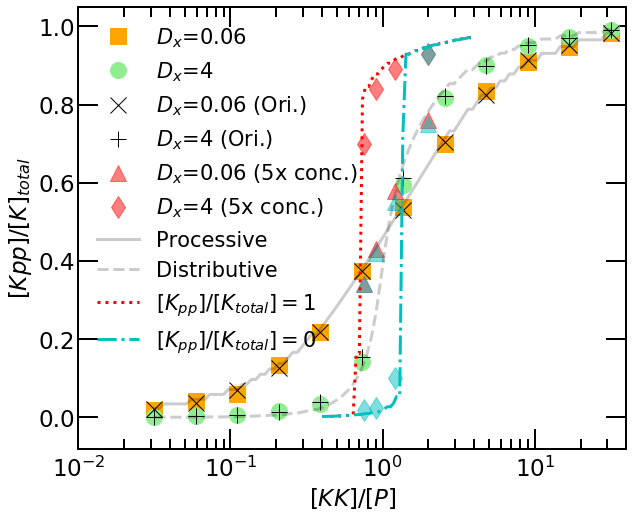

In [15]:
import os
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

fs=23
ms=16
lw=3
fig,ax1=plt.subplots(1,1,figsize=(8.6,7))

#load and plot ODE result
proc=np.loadtxt("data/MAPK_ODE_proc",delimiter=',')
dist=np.loadtxt("data/MAPK_ODE_dist",delimiter=',')    
#ax1.semilogx(proc[:,0],proc[:,1],'-',label='Processive',linewidth=lw)
#ax1.semilogx(dist[:,0],dist[:,1],'--',label='Distributive',linewidth=lw)

#load and plot spatiocyte data
def plotspa(name,nam,c,clr,label): 
    names = os.listdir(name)
    lst = []
    for n in names:
        dat = np.loadtxt(name+n)
        lst.append(dat)
    lst = np.sort(lst,axis=0)    
    ax1.semilogx(lst[:,0],lst[:,1],c,label=label,markersize=ms,color=clr)
    ax1.legend()

plotspa("/home/chew/wrk/ecellwork/MLM/data/mapk_sc_D0.060/",0.06,'s','orange','$D_x$=0.06')
plotspa("/home/chew/wrk/ecellwork/MLM/data/mapk_sc_D4.000/",4,'o','lightgreen','$D_x$=4')
plotspa("/home/chew/wrk/ecellwork/MLM/data/mapk_D0.06/",0.06,'x','k','$D_x$=0.06 (Ori.)')
plotspa("/home/chew/wrk/ecellwork/MLM/data/mapk_D4/",4,'+','k','$D_x$=4 (Ori.)')

RRup = [0.75,0.9,1.2,2]
RRbt = [0.75,0.9,1.2,2]
YYup=[0.34,0.43,0.58,0.76]
YYbt=[0.34,0.42,0.55,0.75]
RR=RRup+RRbt
YY = YYup+YYbt
ax1.plot(RRup,YYup,'r^',markersize=ms,label='$D_x$=0.06 (5x conc.)',alpha=0.5)
ax1.plot(RRbt,YYbt,'c^',markersize=ms,alpha=0.5)

#trel=1us,D=4

YYup=[0.7,0.84,0.89,0.93]
YYbt=[0.018,0.025,0.1,0.93]
YY = YYup+YYbt
ax1.plot(RRup,YYup,'rd',label='$D_x$=4 (5x conc.)',markersize=ms,alpha=0.5)
ax1.plot(RRbt,YYbt,'cd',markersize=ms,alpha=0.5)


ax1.semilogx(proc[:,0],proc[:,1],'k-',label='Processive',linewidth=lw,alpha=0.2)
ax1.semilogx(dist[:,0],dist[:,1],'k--',label='Distributive',linewidth=lw,alpha=0.2)
ax1.set_ylim(-0.08,1.05)
ax1.set_xlim(0.01,40)
ax1.set_xlabel('$[KK]/[P]$',fontsize=fs)
ax1.set_ylabel('$[Kpp]/[K]_{total}$',fontsize=fs)

#ODE result of bistability case
name='/home/chew/wrk/ecellwork/MLM/data/MAPK_ODE_dist_bistable_frm_above'
dat=np.genfromtxt(name,delimiter=',').T
X=dat[0]
Y=dat[1]
ax1.semilogx(X,Y,'r',linestyle='dotted',linewidth=lw,label='$[K_{pp}]/[K_{total}]=1$')
name='/home/chew/wrk/ecellwork/MLM/data/MAPK_ODE_dist_bistable_frm_bottom'
dat=np.genfromtxt(name,delimiter=',').T
X=dat[0]
Y=dat[1]
ax1.semilogx(X,Y,'c-.',linewidth=lw,label='$[K_{pp}]/[K_{total}]=0$')

ax1.legend(loc='best',fontsize=fs-2,frameon=False)
ax1.tick_params(labelsize=fs)

ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(axis='both',which='both',direction='in',length=10,width=2)
ax1.tick_params(axis='both',which='major',length=20,width=2)
ax1.tick_params(axis='x',which='major',pad=8)
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
fig.tight_layout(pad=0)        